In [1]:
# Modeling Biological Networks Assignment
# Jan Sternagel, 102177941
import numpy as np
import pandas as pd
import pysindy as ps


/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


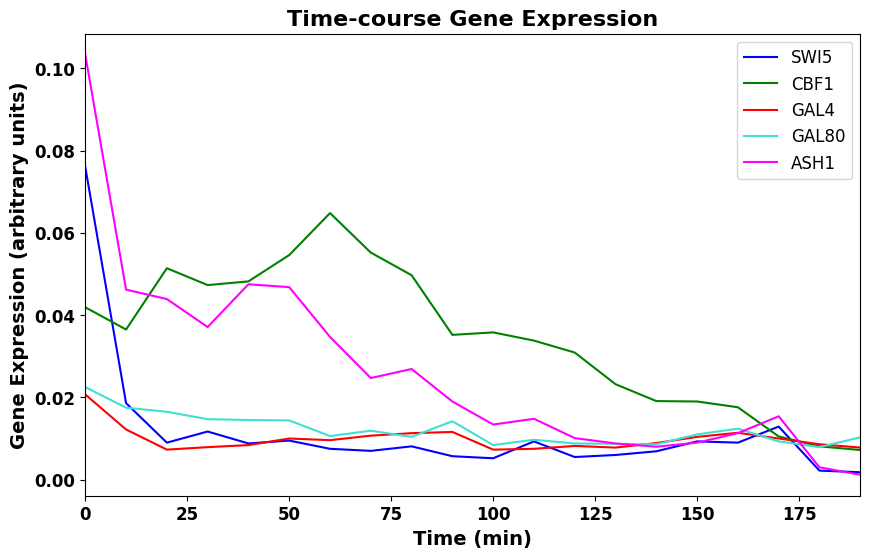

In [2]:
from src.commons import read_data
from src.visuals import show_gene_expression_over_time_in_one_plot

t, data_gen_exp_t = read_data('data/data_original.json')

dt = 10  # min
max_time = max(t)

t_data = np.array(t)
x_true = np.array(list(data_gen_exp_t.values())).T

show_gene_expression_over_time_in_one_plot(t, data_gen_exp_t)

# Gradient Estimation
Using brute force for all  possible ODE models.
PySINDy is a good library for that and will be used a lot

In [8]:
# Sadly the data is WAY too little. Let's fake 500 repeats of the same experiment with an unrealistic noise. In the future we would need to messure much more!
n_trajectories = 500
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(x_true + np.random.normal(0, 0.00001, x_true.shape))

In [9]:
# Define the library and identify all the features
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(x_true, {"ax_sample": 0, "ax_coord": 1})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

Features (21): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']


In [10]:
# 1. Start of with an unconstrained model to establish a baseline, this is very over-fitted!
# ps.STLSQ(threshold=0.001) is the default optimizer. It uses a sparse regression to find the best model.
model_unconstrained = ps.SINDy(optimizer=ps.STLSQ(threshold=0.001), feature_library=library)
model_unconstrained.fit(x_true, t=1)
# model_unconstrained.fit(x_train_multi, t=dt, multiple_trajectories=True)
print("Unconstrained Model:")
model_unconstrained.print()

Unconstrained Model:
(x0)' = -0.054 1 + 3.013 x0 + 0.188 x1 + 1.089 x2 + 5.090 x3 + 0.512 x4 + -26.539 x0^2 + 40.165 x0 x1 + 189.804 x0 x2 + -555.316 x0 x3 + 60.602 x0 x4 + -9.736 x1 x4 + -142.088 x2 x4 + -63.912 x3 x4 + 22.536 x4^2
(x1)' = 0.001 1 + 1.261 x0 + 0.098 x1 + -0.403 x2 + -1.211 x4 + -40.492 x0^2 + -0.613 x0 x4 + 23.938 x4^2
(x2)' = -0.036 x0 + 0.304 x2 + -0.266 x3 + -0.025 x4 + -2.928 x0 x4 + 1.628 x4^2
(x3)' = -0.190 x0 + 0.021 x1 + 0.062 x2 + 0.211 x3 + -0.171 x4 + 1.715 x4^2
(x4)' = -0.088 1 + 2.336 x0 + 0.316 x1 + 3.566 x2 + 6.516 x3 + 2.086 x4 + -179.006 x0^2 + 81.262 x0 x1 + 533.382 x0 x2 + -825.383 x0 x3 + 181.307 x0 x4 + -34.795 x1 x4 + -355.141 x2 x4 + -99.197 x3 x4 + 41.394 x4^2


In [11]:
from src.pysindy_gradiet_estimation import process_coefficient_matrix

feature_biological_names = ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"]
coefficient_matrix = process_coefficient_matrix(model_unconstrained.coefficients(), feature_biological_names,
                                                library.get_feature_names())
fpr, tpr = calculate_confusion_matrix_from_model(coefficient_matrix, compare_aginst_switch_off_sereies=False,
                                                 undirected_model=False)

In [12]:
model_true_model = {
    'SWI5': [None, 1, 0, 1, 1],
    'CBF1': [0, None, 1, 0, 0],
    'GAL4': [1, 0, None, -0.5, 0],
    'GAL80': [0, 0, -0.5, None, 0],
    'ASH1': [0, -1, 0, 0, None]
}

Model score against true model: -78.746599


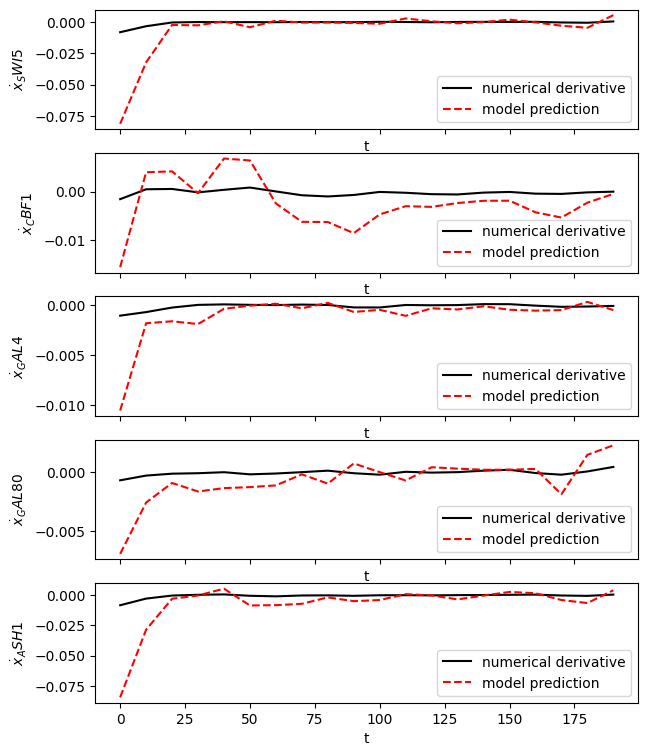

In [13]:
from src.visuals import plot_model_prediction

print("Model score against true model: %f" % model_unconstrained.score(x_true, t=dt))
plot_model_prediction(model_unconstrained, x_true, dt, max_time)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.010526315789473684) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.010526315789473684) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015789473684210527) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq

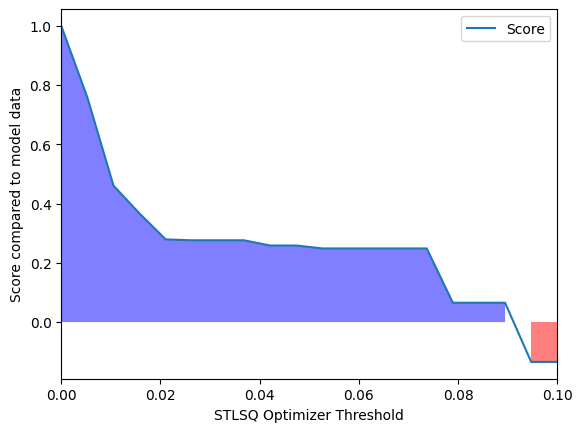

In [15]:
from src.visuals import plot_scores_over_threshold

# 2. Experiment with the threshold
threshold_scan = np.linspace(0, 0.1, 20)
scores = []
for i, threshold in enumerate(threshold_scan):
    optimizer = ps.STLSQ(threshold=threshold)
    model_threshold = ps.SINDy(optimizer=optimizer, feature_library=library)
    # model_threshold.fit(x_true, t=dt)
    model_threshold.fit(x_train_multi, t=dt, multiple_trajectories=True)
    scores.append(model_threshold.score(x_true, t=dt))

plot_scores_over_threshold(threshold_scan, scores)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0182) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0182) and eliminated all coefficients
  warnings.warn(


Best threshold model:
(x0)' = -0.076 x0 + 0.033 x1 + -0.035 x4
(x1)' = -0.038 x0 + -0.041 x2 + 0.023 x4
(x2)' = 0.000
(x3)' = 0.000
(x4)' = -0.127 x0 + 0.065 x2
Model score against true model: 0.425627


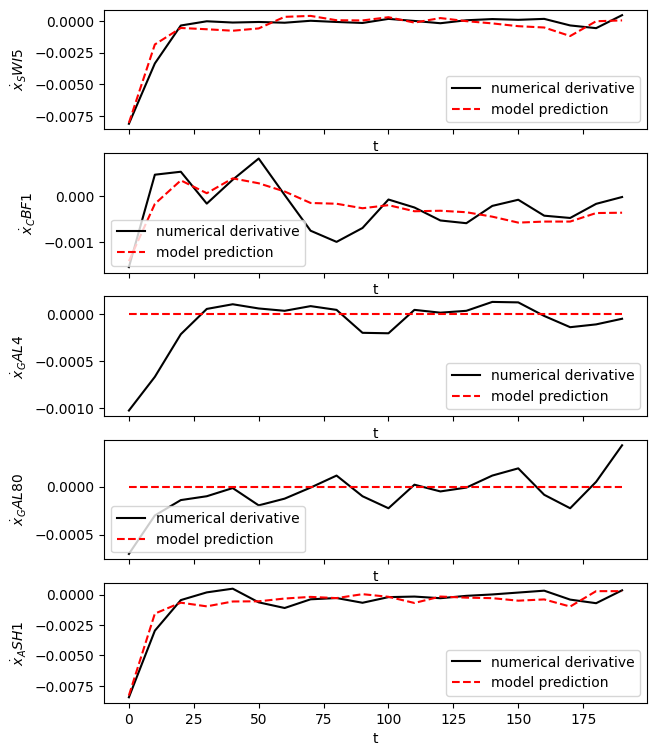

In [16]:
from src.visuals import create_graph_from_model, draw_graph, format_model_for_graph_plot

# Pick the "best" one manually and view it
model_threshold_best = ps.SINDy(optimizer=ps.STLSQ(threshold=0.0182), feature_library=library)
# model_threshold_best.fit(x_true, t=dt)
model_threshold_best.fit(x_train_multi, t=dt, multiple_trajectories=True)
print("Best threshold model:")
model_threshold_best.print()

print("Model score against true model: %f" % model_threshold_best.score(x_true, t=dt))
plot_model_prediction(model_threshold_best, x_true, dt, max_time)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.007070707070707071) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.007070707070707071) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.00808080808080808) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.

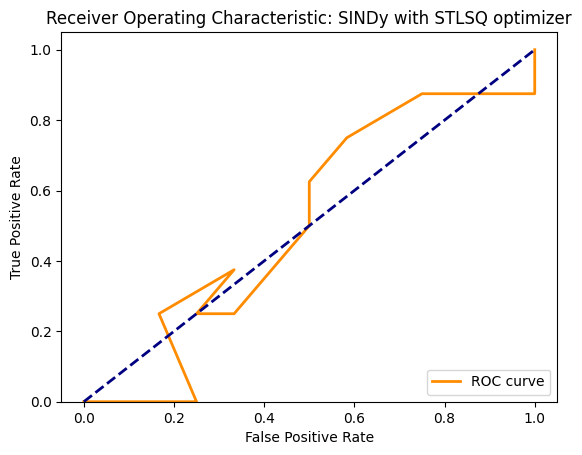

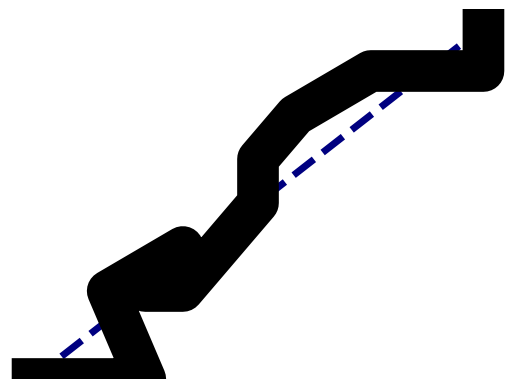

In [17]:
from src.pysindy_gradiet_estimation import process_coefficient_matrix

feature_biological_names = ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"]

threshold_scan = np.linspace(0.0, 0.1, 100)
fprs, tprs = [], []
for i, threshold in enumerate(threshold_scan):
    optimizer = ps.STLSQ(threshold=threshold)
    model_threshold = ps.SINDy(optimizer=optimizer, feature_library=library)
    # model_threshold.fit(x_true, t=dt)
    model_threshold.fit(x_train_multi, t=dt, multiple_trajectories=True)

    coefficient_matrix = process_coefficient_matrix(model_threshold.coefficients(), feature_biological_names,
                                                    library.get_feature_names())
    fpr, tpr = calculate_confusion_matrix_from_model(coefficient_matrix, compare_aginst_switch_off_sereies=False,
                                                     consider_inhibition=False,
                                                     undirected_model=False)
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc(fprs, tprs, "Receiver Operating Characteristic: SINDy with STLSQ optimizer")
plot_roc_simplified(fprs, tprs)

In [155]:
vals = []
for tpr, fpr in zip(tprs, fprs):
    vals.append(np.sqrt(tpr ** 2 + (1 - fpr) ** 2))

threshold_scan[vals.index(min(vals))]

0.00808080808080808

Equality Constrained Model
(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.000
(x3)' = 0.000
(x4)' = 0.000
Model score against true model: -0.134411


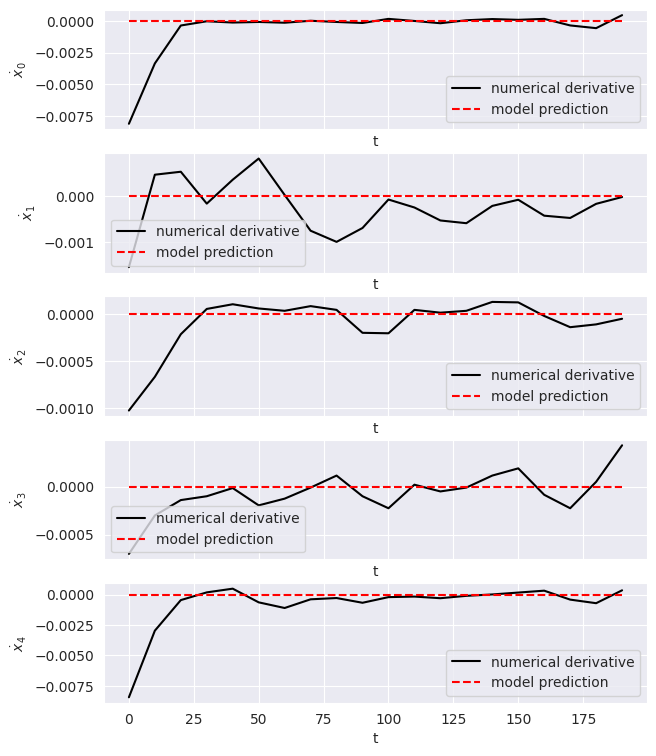

In [25]:
from src.pysindy_gradiet_estimation import translate_model_to_spare_array, pruned_model_optimizer_equality

rna_to_element_translation: dict = {"SWI5": "x0", "CBF1": "x1", "GAL4": "x2", "GAL80": "x3", "ASH1": "x4"}

model_equality_constrained_only_linear = {
    "SWI5": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "CBF1": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "GAL4": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "GAL80": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"],
    "ASH1": ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"]
}

model_equality_constrained_true_model = {
    "SWI5": ["GAL4"],
    "CBF1": ["SWI5", "ASH1"],
    "GAL4": ["CBF1", "GAL80"],
    "GAL80": ["SWI5"],
    "ASH1": ["SWI5"]
}

# Select which one to chose
selected_model = model_equality_constrained_true_model

translated_model = translate_model_to_spare_array(rna_to_element_translation, library.get_feature_names(),
                                                  selected_model)
# what kind of constraint does this model use? 
model_equality_constrained = ps.SINDy(
        optimizer=pruned_model_optimizer_equality(translated_model),
        feature_library=library
)
# model_equality_constrained.fit(x_true, t=dt)
model_equality_constrained.fit(x_train_multi, t=dt, multiple_trajectories=True)
print("Equality Constrained Model")
model_equality_constrained.print()
print("Model score against true model: %f" % model_equality_constrained.score(x_true, t=dt))
plot_model_prediction(model_equality_constrained, x_true, dt, max_time)


# Exhaustiv Search with Cross-Validation

In [26]:
from sklearn.metrics import r2_score


class SINDyCV(ps.SINDy):
    def __init__(
            self,
            optimizer=None,
            feature_library=None,
            differentiation_method=None,
            feature_names=None,
            t_default=1,
            discrete_time=False,
    ):
        super(SINDyCV, self).__init__(
                optimizer=optimizer,
                feature_library=feature_library,
                differentiation_method=differentiation_method,
                feature_names=feature_names,
                t_default=t_default,
                discrete_time=discrete_time,
        )

    def fit(self, x, y, **kwargs):
        return super(SINDyCV, self).fit(x, x_dot=y, **kwargs)

    def score(
            self,
            x,
            y,
            t=None,
            u=None,
            multiple_trajectories=False,
            metric=r2_score,
            **metric_kws
    ):
        return super(SINDyCV, self).score(
                x,
                x_dot=y,
                t=t,
                u=u,
                multiple_trajectories=multiple_trajectories,
                metric=metric,
                **metric_kws
        )

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  warnings.warn(
/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too

Best parameters: {'feature_library__degree': 1, 'optimizer__alpha': 0.001, 'optimizer__threshold': 0.01}
Best score: 0.051176389357463846
(x0)' = -0.076 x0 + 0.033 x1 + -0.035 x4
(x1)' = -0.018 x0
(x2)' = 0.000
(x3)' = 0.000
(x4)' = -0.094 x0 + 0.020 x1 + -0.018 x4


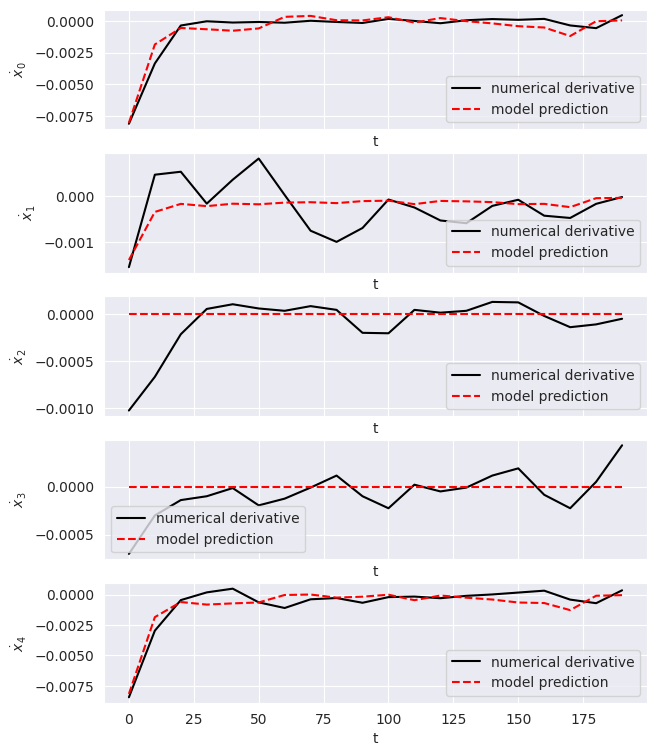

In [27]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold

KFold(n_splits=10)

model = SINDyCV()
x_dot = model.differentiate(x_true, t=t_data)

param_grid = {
    "optimizer__threshold": [0.0, 0.0001, 0.001, 0.01, 0.015, 0.02],
    "optimizer__alpha": [0.00001, 0.001, 0.005, 0.01, 0.05, 0.1, 0],
    "feature_library__degree": [1, 2],
}

search = GridSearchCV(
        model,
        param_grid,
        cv=ShuffleSplit(n_splits=5, test_size=0.7)
)
search.fit(x_true, y=x_dot)
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)
search.best_estimator_.print()

plot_model_prediction(search.best_estimator_, x_true, dt, max_time)

# PySINDy with paper restriction
Only linear and 

In [36]:
from src.pysindy_gradiet_estimation import translate_model_to_spare_array, pruned_model_optimizer_equality


def analyze_filtered_model(selected_model, execute_plots=False):
    rna_to_element_translation: dict = {"SWI5": "x0", "CBF1": "x1", "GAL4": "x2", "GAL80": "x3", "ASH1": "x4"}

    translated_model = translate_model_to_spare_array(rna_to_element_translation, library.get_feature_names(),
                                                      selected_model)
    # what kind of constraint does this model use? 
    model_equality_constrained = ps.SINDy(
            optimizer=pruned_model_optimizer_equality(translated_model),
            feature_library=library
    )
    # model_equality_constrained.fit(x_true, t=dt)
    model_equality_constrained.fit(x_train_multi, t=dt, multiple_trajectories=True)
    score = model_equality_constrained.score(x_true, t=dt)
    if execute_plots:
        plot_model_prediction(model_equality_constrained, x_true, dt, max_time)

    return score, model_equality_constrained.coefficients()

In [103]:
from itertools import combinations

combination_matrix = []
for defined_variable in feature_biological_names:

    # Remove the defined variable from the list to avoid duplicating it in combinations
    remaining_variables = [var for var in feature_biological_names if var != defined_variable]

    # Initialize a list to store all combinations
    all_combinations = []

    # Generate combinations of 0, 1, and 2 additional variables
    for r in range(3):  # r represents the number of additional variables (0 to 2)
        for combo in combinations(remaining_variables, r):
            # Add the defined variable back to each combination
            all_combinations.append([defined_variable] + list(combo))
            # all_combinations.append(list(combo))

    combination_matrix.append(all_combinations)

print(combination_matrix)

[[['SWI5'], ['SWI5', 'CBF1'], ['SWI5', 'GAL4'], ['SWI5', 'GAL80'], ['SWI5', 'ASH1'], ['SWI5', 'CBF1', 'GAL4'], ['SWI5', 'CBF1', 'GAL80'], ['SWI5', 'CBF1', 'ASH1'], ['SWI5', 'GAL4', 'GAL80'], ['SWI5', 'GAL4', 'ASH1'], ['SWI5', 'GAL80', 'ASH1']], [['CBF1'], ['CBF1', 'SWI5'], ['CBF1', 'GAL4'], ['CBF1', 'GAL80'], ['CBF1', 'ASH1'], ['CBF1', 'SWI5', 'GAL4'], ['CBF1', 'SWI5', 'GAL80'], ['CBF1', 'SWI5', 'ASH1'], ['CBF1', 'GAL4', 'GAL80'], ['CBF1', 'GAL4', 'ASH1'], ['CBF1', 'GAL80', 'ASH1']], [['GAL4'], ['GAL4', 'SWI5'], ['GAL4', 'CBF1'], ['GAL4', 'GAL80'], ['GAL4', 'ASH1'], ['GAL4', 'SWI5', 'CBF1'], ['GAL4', 'SWI5', 'GAL80'], ['GAL4', 'SWI5', 'ASH1'], ['GAL4', 'CBF1', 'GAL80'], ['GAL4', 'CBF1', 'ASH1'], ['GAL4', 'GAL80', 'ASH1']], [['GAL80'], ['GAL80', 'SWI5'], ['GAL80', 'CBF1'], ['GAL80', 'GAL4'], ['GAL80', 'ASH1'], ['GAL80', 'SWI5', 'CBF1'], ['GAL80', 'SWI5', 'GAL4'], ['GAL80', 'SWI5', 'ASH1'], ['GAL80', 'CBF1', 'GAL4'], ['GAL80', 'CBF1', 'ASH1'], ['GAL80', 'GAL4', 'ASH1']], [['ASH1'], ['ASH

In [107]:
results = []


def identify_combinations(feature_biological_names, combination_matrix, model={}, index=0):
    global results
    if index == len(feature_biological_names):
        score, model_coefficients = analyze_filtered_model(model)
        if score > 0.0:
            results.append([score, model_coefficients])
            print(score)
        return
    for combination in combination_matrix[index]:
        new_model = model.copy()
        new_model[feature_biological_names[index]] = combination
        identify_combinations(feature_biological_names, combination_matrix, new_model, index + 1)

# identify_combinations(feature_biological_names, combination_matrix)

In [37]:
#
model_equality_constrained_true_model = {
    "SWI5": ["GAL4"],
    "CBF1": ["SWI5", "ASH1"],
    "GAL4": ["CBF1", "GAL80"],
    "GAL80": ["SWI5"],
    "ASH1": ["SWI5"]
}

analyze_filtered_model(model_equality_constrained_only_linear)

/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/pysindy/optimizers/constrained_sr3.py:463: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


(-32.99713889671397,
 array([[ 0.        , -0.        ,  0.        , -0.68403539,  0.63470826,
         -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.        ,  0.        ,  0.        ,
          0.        , -0.        ,  0.        ,  0.        ,  0.        ,
         -0.        ],
        [ 0.        , -1.17222474, -0.3399651 ,  3.69479346, -2.797826  ,
          0.85191204,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.        , -0.        , -0.        ,
         -0.        ],
        [ 0.        ,  0.12066297,  0.        , -0.5427699 ,  0.46634878,
         -0.10230388,  0.        ,  0.        , -0.        , -0.        ,
         -0.        , -0.        , -0.        , -0.        , -0.        ,
          0.        ,  0.        , -0.        , -0.        ,  0.        ,
          0.        ],
        [ 0.        , 